# From this notebook I created the `autocorr_empirical_run.py` file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import random
import string
import os
import glob
my_path = Path('/home/adameshel/Documents/code/autocorr/')
from autocorr_functions import *
import autocorr_cmls as accml

In [3]:
raw_path = Path('/home/adameshel/Documents/code/kit_code/\
2d_method_intercomparison/data/raw/')
fig_path = Path('/home/adameshel/Documents/code/autocorr/semi_real/')

list_of_datasets = []
ds_radolan = xr.open_mfdataset(
    str(raw_path.joinpath('radklim_yw_for_adam.nc').absolute()),
                              combine='by_coords'
                              )

In [4]:
from pyproj import Proj, transform
import scipy.stats as stats
import sys
from pathlib import Path
# sys.path.append("../Iterative/")
# sys.path.append("../Kriging/")
sys.path.append("/home/adameshel/Documents/code/my_functions/")
from geoFunc import *
import iterative_IDW_V1 as gmz
import kriging as krg
sys.path.append("/home/adameshel/Documents/code/") 
from helper_functions import split_at

In [16]:
agg_times = ['30T']
start_time_idx = 0#15
end_time_idx = -1#70#340#len(ds_radolan_cut.time)
mult = 20 # simply for making the rain stronger
############################
####### CHANGE DOMAIN ######
## Medium cut
min_lat = 47.6890
min_lon = 8.1873
max_lat = 49.1185
max_lon = 10.0978

# min_lat = 47.8890
# min_lon = 8.9873
# max_lat = 49.2185
# max_lon = 10.6978

## Interesting cut big rectangle south
# min_lat = 48.000
# min_lon = 8.2000
# max_lat = 50.00
# max_lon = 11.5000

ds_radolan_cut = ds_radolan.where((ds_radolan['latitudes'] >= min_lat) &
                                 (ds_radolan['latitudes'] <= max_lat) & 
                                 (ds_radolan['longitudes'] >= min_lon) &
                                 (ds_radolan['longitudes'] <= max_lon),
                                 drop=True)

proj_degrees = Proj(init='epsg:4326')
proj_meters = Proj(init='epsg:3043')#3857 FROM MAX  #3395 #3043 UTM

# from pyproj import Transformer
x_grid_utm, y_grid_utm = transform(proj_degrees, 
                         proj_meters, 
                         ds_radolan_cut.longitudes.values, 
                         ds_radolan_cut.latitudes.values)


# transformer = Transformer.from_proj(proj_degrees, proj_meters)
# x_grid_utm, y_grid_utm = transformer.transform(
#     ds_radolan_cut.longitudes.values, 
#     ds_radolan_cut.latitudes.values
# )

ds_radolan_cut.coords['x_utm'] = (('y', 'x'), x_grid_utm)
ds_radolan_cut.coords['y_utm'] = (('y', 'x'), y_grid_utm)

# time_frame = ds_radolan_along_cml_cut.time[start_time_idx:end_time_idx]
time_frame = ds_radolan_cut.time[start_time_idx:end_time_idx]
num_of_ts = len(time_frame)
ds_radolan_GT = ds_radolan_cut.where(ds_radolan_cut.time == \
             ds_radolan_cut.time[start_time_idx:end_time_idx])
ds_radolan_GT = ds_radolan_GT.rename({'rainfall_amount':'raindepth'})

import pycomlink as pycml
from pykrige.ok import OrdinaryKriging
import pickle as pkl

rain_mat = ds_radolan_GT.raindepth.values * mult#12 # to make it mm/h
del ds_radolan_GT
ds_radolan_GT = xr.Dataset(
    data_vars={'raindepth': (('time','y', 'x'), rain_mat)},
    coords={'lon_grid': (('y', 'x'), ds_radolan_cut.longitudes.values),
            'lat_grid': (('y', 'x'), ds_radolan_cut.latitudes.values),
            'x_utm': (('y', 'x'), ds_radolan_cut.x_utm.values),
            'y_utm': (('y', 'x'), ds_radolan_cut.y_utm.values),
            'time': time_frame,
            'x': ds_radolan_cut.x.values,
            'y': ds_radolan_cut.y.values})

def cml_lat_lon_to_UTM(df):
    df['xa'], df['ya'] = transform(proj_degrees, 
                                   proj_meters, 
                                   df['site_a_longitude'].values, 
                                   df['site_a_latitude'].values)
    df['xb'], df['yb'] = transform(proj_degrees, 
                                   proj_meters, 
                                   df['site_b_longitude'].values, 
                                   df['site_b_latitude'].values)
    return df

def link_id_gen(num_of_ids=1, size=8, chars=string.ascii_uppercase + string.digits):
    my_id_list = list()
    for i in range(num_of_links):
        my_id = ''.join(random.choice(chars) for _ in range(size))
        my_id_list.append(my_id[:4] + '-' + my_id[4:])
    return my_id_list

/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code

# Try your rain-field

22
23
24
25
26


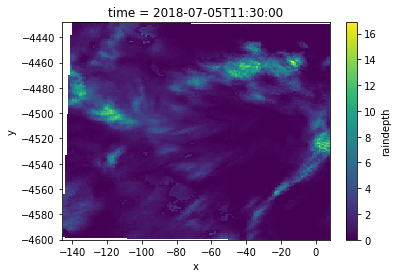

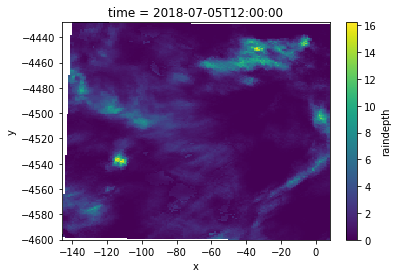

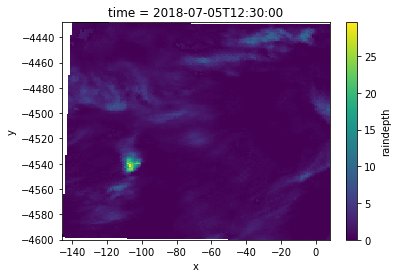

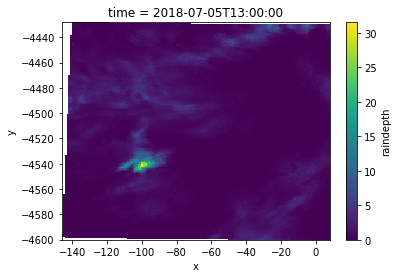

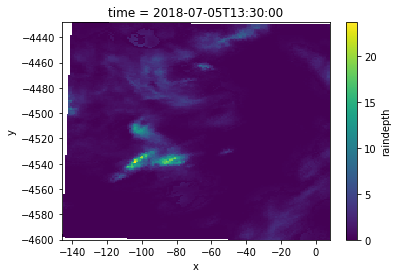

In [26]:
ts=22#20#120#22#3*17 #timestamp
cod = 40#60000 #cutoff distance (km)

for i in range(5):
    print(ts+i)
    fig, ax = plt.subplots()
    ds_radolan_GT.resample(
        time=agg_times[0], label='right', 
        restore_coord_dims=False).mean(dim='time').isel(time=ts+i).raindepth.plot()
    
# globals()["ds_radolan_GT_" + agg_times[0]]

# Generate links with identical lengths

In [21]:
import autocorr_cmls as accml
opt = True
bandwidth = 1.0 # km
# fig_path_current = fig_path.joinpath(str(agg_times[0]) + '_ts' +\
#                                      str(ts) + 'TRY_cod' + str(int(cod)) +\
#                                     'opt' + str(opt))
# try:
#     os.mkdir(fig_path_current)
# except:
#     nothing = 0
links_density = 0.012 # km**-2 

km_in_start = 11
km_in_end = -12
x1 = ds_radolan_GT.x_utm.values[km_in_start:km_in_end]
y1 = ds_radolan_GT.y_utm.values[km_in_start:km_in_end]

cml_lengths = np.linspace(0.1,28,20)
cml_cent_sim = range(1)

for il, l in enumerate(cml_lengths):
    length_name = round(l,1)
    length_name = split_at(str(format(length_name/100, '.3f')),'.',1)[-1]
    globals()['ac_par_il_' + length_name] = np.array([999,999])
    with open(fig_path_current.joinpath('ac_par_il_' + length_name + '.pkl'), 'wb') as f:
        pkl.dump(globals()['ac_par_il_' + length_name], f)
    f.close()

for ic, c in enumerate(cml_cent_sim):
    print('ITERATION %i' %ic)
    x = []
    y = []
    for i in range(len(x1)):
        x_temp = x1[i][km_in_start:km_in_end]
        y_temp = y1[i][km_in_start:km_in_end]
        x.append(x_temp)
        y.append(y_temp)
    x = np.array(x)
    y = np.array(y)
    bools = np.random.uniform(0,1,len(x.ravel())) > (1-links_density)
    x_links_cent = np.compress(bools,x)
    y_links_cent = np.compress(bools,y)

    num_of_links = len(y_links_cent)
    print('NUM OF LINKS IS %i' %num_of_links)

    x_links_cent = x_links_cent + np.random.normal(loc=0.0,scale=10.2, size=num_of_links)
    y_links_cent = y_links_cent + np.random.normal(loc=0.0,scale=10.2, size=num_of_links)

    links_cent = np.column_stack((x_links_cent,y_links_cent))

    cml_ids = link_id_gen(num_of_ids=num_of_links)

    for il, l in enumerate(cml_lengths):
        print('LENGTHS: %.2f' %l)
        links_lengths = l * 1000#np.ones(shape=[num_of_links,1])
        ang = np.radians(np.random.uniform(low=0.0, high=179.9999, size=[num_of_links,1]))
        ang = np.squeeze(ang)
        links_xa = (-links_lengths/2)*np.cos(ang) + links_cent[:,0] #+ 672.2919656637181
        links_ya = (-links_lengths/2)*np.sin(ang) + links_cent[:,1] #+ 3562.7985050678294
        links_xb = (links_lengths/2)*np.cos(ang) + links_cent[:,0] #+ 672.2919656637181
        links_yb = (links_lengths/2)*np.sin(ang) + links_cent[:,1] #+ 3562.7985050678294
        
        lons_a, lats_a = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xa, 
                                 links_ya)
        lons_b, lats_b = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xb, 
                                 links_yb)

        df_sim_input = pd.DataFrame(columns= ['cml_id',
                                              'site_a_longitude',
                                              'site_b_longitude',
                                              'site_a_latitude',
                                              'site_b_latitude',
                                              'Frequency',
                                              'Length',
                                              'Polarization','a','b','time','R_radolan','A'])

        df_sim_input['cml_id'] = cml_ids

#         df_sim_input['Frequency'] = np.random.choice([8, 18, 23, 38], df_sim_input.shape[0])
        df_sim_input['Frequency'] = 23
        df_sim_input['site_a_longitude'], df_sim_input['site_a_latitude'] = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xa, 
                                 links_ya)
        df_sim_input['site_b_longitude'], df_sim_input['site_b_latitude'] = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xb, 
                                 links_yb)
        df_sim_input['Polarization'] = np.random.choice(['H', 'V', 'V'], df_sim_input.shape[0])
        df_sim_input['Length'] = links_lengths / 1e3 # km

        for i, cml in df_sim_input.iterrows():
            df_sim_input.loc[i,'a'], df_sim_input.loc[i,'b'] = \
                pycml.processing.A_R_relation.A_R_relation.a_b(
                    cml['Frequency'],
                    cml['Polarization'])

        df_sim_input.drop(['time'],axis='columns',inplace=True)
        # df_sim_input = df_sim_input.drop_vars('time')

        d_weights = {}
        for j, cml in enumerate(df_sim_input.cml_id.values): 
            intersec_weights = pycml.validation.validator.calc_intersect_weights(
                        x1_line=df_sim_input.site_a_longitude.values[j],
                        y1_line=df_sim_input.site_a_latitude.values[j],
                        x2_line=df_sim_input.site_b_longitude.values[j],
                        y2_line=df_sim_input.site_b_latitude.values[j],
                        x_grid=ds_radolan_GT.lon_grid.values,
                        y_grid=ds_radolan_GT.lat_grid.values,
                        grid_point_location='center')
            d_weights[cml] = intersec_weights


        list_of_GT_datasets = []
        list_of_radolan_along_cml = []
        QUANT = 'with'
        NOISE = 'with'

        for _, agg in enumerate(agg_times):
            print(str("ds_radolan_GT_" + agg))
            num_of_mins = float(split_at(agg,'T',1)[0])

            globals()["ds_radolan_GT_" + agg] = ds_radolan_GT.resample(
                time=agg, label='right', 
                restore_coord_dims=False).mean(dim='time')
            list_of_GT_datasets.append(str("ds_radolan_GT_" + agg))

            path_ave_time = np.zeros(
                (len(df_sim_input.cml_id)))
            for j, cml in enumerate(df_sim_input.cml_id.values):
                path_ave_time[j] = round(
                    np.nansum(d_weights[cml] * globals()["ds_radolan_GT_" + agg].\
                               raindepth.isel(time=ts).values), 
                                                6)# * intensity_factor)

            df_sim_input['R_radolan'] = path_ave_time

        df_sim_input.rename(columns = {'cml_id':'Link_num',
                                              'R_radolan':'R',
                                              'Length':'L',
                                              'Frequency':'F'}, 
                                   inplace=True)
        df_sim_input = cml_lat_lon_to_UTM(df_sim_input)
        df_sim_input, _ = gmz.create_virtual_gauges(df_sim_input, 
                                        num_gauges=1)
        if ic==0 and il==0:
            df = df_sim_input.copy()
        ac = accml.Autocorr(df_sim_input, bw=bandwidth, cutoff_distance_km=cod)
        ac(optimize=opt)

        print('\n\n')
        length_name = round(l,1)
        length_name = split_at(str(format(length_name/100, '.3f')),'.',1)[-1]
        if ac.alpha_L * ac.beta_L <= 0:
            with open(fig_path_current.joinpath(
                      'ac_par_il_' + length_name + '.pkl'), 
                      'rb') as f:
                arr = pkl.load(f)
            f.close()
            arr = np.row_stack((arr,np.array([666,666])))
            with open(fig_path_current.joinpath(
                      'ac_par_il_' + length_name + '.pkl'), 
                      'wb') as f:
                pkl.dump(arr, f)
            f.close()
        else:
            with open(fig_path_current.joinpath(
                      'ac_par_il_' + length_name + '.pkl'), 
                      'rb') as f:
                arr = pkl.load(f)
            f.close()
            arr = np.row_stack((arr,np.array( [ac.alpha_L, ac.beta_L] )))
            with open(fig_path_current.joinpath(
                      'ac_par_il_' + length_name + '.pkl'), 
                      'wb') as f:
                pkl.dump(arr, f)
            f.close()

ITERATION 0
NUM OF LINKS IS 258
LENGTHS: 0.10


/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ds_radolan_GT_90T


/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1





LENGTHS: 1.57
ds_radolan_GT_90T



LENGTHS: 3.04
ds_radolan_GT_90T



LENGTHS: 4.51


KeyboardInterrupt: 

In [7]:
###### import autocorr_cmls as accml
identical_l = False
if identical_l is False:
    shortest = 10.1; longest = 10.1
    diff = longest - shortest
    lag = diff / 5
    shortest = shortest + lag
    longest = longest - lag
    
opt = True
bandwidth = 1.0 # km
# fig_path_current = fig_path.joinpath(str(agg_times[0]) + '_ts' +\
#                                      str(ts) + 'TRY_cod' + str(int(cod)) +\
#                                     'opt' + str(opt))
# try:
#     os.mkdir(fig_path_current)
# except:
#     nothing = 0
links_density = 0.05# 0.012 # km**-2 

km_in_start = 11
km_in_end = -12
x1 = ds_radolan_GT.x_utm.values[km_in_start:km_in_end]
y1 = ds_radolan_GT.y_utm.values[km_in_start:km_in_end]

cml_lengths = np.linspace(shortest,longest,1)
cml_cent_sim = range(1)

for il, l in enumerate(cml_lengths):
    length_name = round(l,1)
    length_name = split_at(str(format(length_name/100, '.3f')),'.',1)[-1]
    globals()['ac_par_il_' + length_name] = np.array([999,999])
#     with open(fig_path_current.joinpath('ac_par_il_' + length_name + '.pkl'), 'wb') as f:
#         pkl.dump(globals()['ac_par_il_' + length_name], f)
#     f.close()

for ic, c in enumerate(cml_cent_sim):
    print('ITERATION %i' %ic)
    x = []
    y = []
    for i in range(len(x1)):
        x_temp = x1[i][km_in_start:km_in_end]
        y_temp = y1[i][km_in_start:km_in_end]
        x.append(x_temp)
        y.append(y_temp)
    x = np.array(x)
    y = np.array(y)
    bools = np.random.uniform(0,1,len(x.ravel())) > (1-links_density)
    x_links_cent = np.compress(bools,x)
    y_links_cent = np.compress(bools,y)

    num_of_links = len(y_links_cent)
    print('NUM OF LINKS IS %i' %num_of_links)

    x_links_cent = x_links_cent + np.random.normal(loc=0.0,scale=10.2, size=num_of_links)
    y_links_cent = y_links_cent + np.random.normal(loc=0.0,scale=10.2, size=num_of_links)

    links_cent = np.column_stack((x_links_cent,y_links_cent))

    cml_ids = link_id_gen(num_of_ids=num_of_links)

    for il, l in enumerate(cml_lengths):
        print('LENGTHS: %.2f' %l)
        links_lengths = l * 1000#np.ones(shape=[num_of_links,1])
        ang = np.radians(np.random.uniform(low=0.0, high=179.9999, size=[num_of_links,1]))
        ang = np.squeeze(ang)
        
        if identical_l is False:
            lower, upper, = (l-lag)*1e3, (l+lag)*1e3 #1.0*1e3, 20*1e3
#             links_mean_length = l * 1e3
#             print(links_mean_length)
#             X = stats.truncexpon(b=(upper-lower)/links_mean_length, loc=lower, scale=links_mean_length)
#             links_lengths = X.rvs(num_of_links)
            links_lengths = np.random.uniform(lower,upper,num_of_links)
            
            
            
        links_xa = (-links_lengths/2)*np.cos(ang) + links_cent[:,0] #+ 672.2919656637181
        links_ya = (-links_lengths/2)*np.sin(ang) + links_cent[:,1] #+ 3562.7985050678294
        links_xb = (links_lengths/2)*np.cos(ang) + links_cent[:,0] #+ 672.2919656637181
        links_yb = (links_lengths/2)*np.sin(ang) + links_cent[:,1] #+ 3562.7985050678294

        lons_a, lats_a = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xa, 
                                 links_ya)
        lons_b, lats_b = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xb, 
                                 links_yb)

        df_sim_input = pd.DataFrame(columns= ['cml_id',
                                              'site_a_longitude',
                                              'site_b_longitude',
                                              'site_a_latitude',
                                              'site_b_latitude',
                                              'Frequency',
                                              'Length',
                                              'Polarization','a','b','time','R_radolan','A'])

        df_sim_input['cml_id'] = cml_ids

#         df_sim_input['Frequency'] = np.random.choice([8, 18, 23, 38], df_sim_input.shape[0])
        df_sim_input['Frequency'] = 23
        df_sim_input['site_a_longitude'], df_sim_input['site_a_latitude'] = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xa, 
                                 links_ya)
        df_sim_input['site_b_longitude'], df_sim_input['site_b_latitude'] = transform(proj_meters, 
                                 proj_degrees, 
                                 links_xb, 
                                 links_yb)
        df_sim_input['Polarization'] = np.random.choice(['H', 'V', 'V'], df_sim_input.shape[0])
        df_sim_input['Length'] = links_lengths / 1e3 # km

        for i, cml in df_sim_input.iterrows():
            df_sim_input.loc[i,'a'], df_sim_input.loc[i,'b'] = \
                pycml.processing.A_R_relation.A_R_relation.a_b(
                    cml['Frequency'],
                    cml['Polarization'])

        df_sim_input.drop(['time'],axis='columns',inplace=True)
        # df_sim_input = df_sim_input.drop_vars('time')

        d_weights = {}
        for j, cml in enumerate(df_sim_input.cml_id.values): 
            intersec_weights = pycml.validation.validator.calc_intersect_weights(
                        x1_line=df_sim_input.site_a_longitude.values[j],
                        y1_line=df_sim_input.site_a_latitude.values[j],
                        x2_line=df_sim_input.site_b_longitude.values[j],
                        y2_line=df_sim_input.site_b_latitude.values[j],
                        x_grid=ds_radolan_GT.lon_grid.values,
                        y_grid=ds_radolan_GT.lat_grid.values,
                        grid_point_location='center')
            d_weights[cml] = intersec_weights


        list_of_GT_datasets = []
        list_of_radolan_along_cml = []
        QUANT = 'with'
        NOISE = 'with'

        for _, agg in enumerate(agg_times):
            print(str("ds_radolan_GT_" + agg))
            num_of_mins = float(split_at(agg,'T',1)[0])

            globals()["ds_radolan_GT_" + agg] = ds_radolan_GT.resample(
                time=agg, label='right', 
                restore_coord_dims=False).mean(dim='time')
            list_of_GT_datasets.append(str("ds_radolan_GT_" + agg))

            path_ave_time = np.zeros(
                (len(df_sim_input.cml_id)))
            for j, cml in enumerate(df_sim_input.cml_id.values):
                path_ave_time[j] = round(
                    np.nansum(d_weights[cml] * globals()["ds_radolan_GT_" + agg].\
                               raindepth.isel(time=ts).values), 
                                                6)# * intensity_factor)

            df_sim_input['R_radolan'] = path_ave_time

        df_sim_input.rename(columns = {'cml_id':'Link_num',
                                              'R_radolan':'R',
                                              'Length':'L',
                                              'Frequency':'F'}, 
                                   inplace=True)
        df_sim_input = cml_lat_lon_to_UTM(df_sim_input)
        df_sim_input, _ = gmz.create_virtual_gauges(df_sim_input, 
                                        num_gauges=1)
        if ic==0 and il==0:
            df = df_sim_input.copy()
        ac = accml.Autocorr(df_sim_input, bw=bandwidth, cutoff_distance_km=cod)
        ac(optimize=opt)

#         print('\n\n')
#         length_name = round(l,1)
#         length_name = split_at(str(format(length_name/100, '.3f')),'.',1)[-1]
#         if ac.alpha_L * ac.beta_L <= 0:
#             with open(fig_path_current.joinpath(
#                       'ac_par_il_' + length_name + '.pkl'), 
#                       'rb') as f:
#                 arr = pkl.load(f)
#             f.close()
#             arr = np.row_stack((arr,np.array([666,666])))
#             with open(fig_path_current.joinpath(
#                       'ac_par_il_' + length_name + '.pkl'), 
#                       'wb') as f:
#                 pkl.dump(arr, f)
#             f.close()
#         else:
#             with open(fig_path_current.joinpath(
#                       'ac_par_il_' + length_name + '.pkl'), 
#                       'rb') as f:
#                 arr = pkl.load(f)
#             f.close()
#             arr = np.row_stack((arr,np.array( [ac.alpha_L, ac.beta_L] )))
#             with open(fig_path_current.joinpath(
#                       'ac_par_il_' + length_name + '.pkl'), 
#                       'wb') as f:
#                 pkl.dump(arr, f)
#             f.close()

ITERATION 0
NUM OF LINKS IS 991
LENGTHS: 10.10


/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:86: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:90: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:112: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ds_radolan_GT_5T


/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/adameshel/anaconda3/envs/cml_env/lib/python3.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


> /home/adameshel/Documents/code/autocorr/autocorr_cmls.py(107)__call__()
-> ihc = np.sum(self.ac[1] >= np.nanmax(self.ac[1]) * 0.05) -1
(Pdb) l
102  	        optimize=True: scipy optimize acf_original to data.
103  	        optimize=False: beta_L is the max value and alpha_L is the
104  	        value of h at which the function lost 95%.
105  	        '''
106  	        import pdb; pdb.set_trace()
107  ->	        ihc = np.sum(self.ac[1] >= np.nanmax(self.ac[1]) * 0.05) -1
108  	        self.nugget = np.nanmedian(self.ac[1][ihc:])
109  	        self.ac[1]
110  	
111  	        # self.nugget = np.min(self.ac[1])
112  	        if optimize==True:
(Pdb) int(len(self.ac[1])/6)
3
(Pdb) mins = int(len(self.ac[1])/6)
(Pdb) np.sort(self.ac[1])[:mins]
array([2.06923698, 2.13735437, 2.19615471])
(Pdb) np.nanmedian(np.sort(self.ac[1])[:mins])
2.1373543688062635
(Pdb) self.nugget = np.nanmedian(np.sort(self.ac[1])[:mins])
(Pdb) self.ac[1][self.ac[1]-self.nugget <= 0] = 0
(Pdb) self.ac[1]
array([9.502

BdbQuit: 

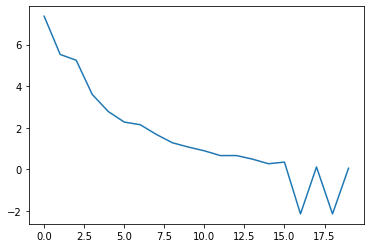

In [10]:
plt.plot(ac.ac[1]-ac.nugget)

In [40]:
links_lengths

array([10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100., 10100., 10100., 10100., 10100.,
       10100., 10100., 10100., 10100.])

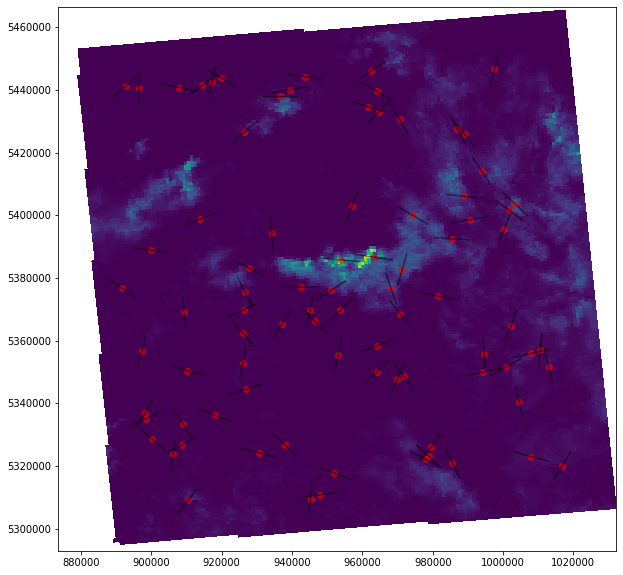

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
pc = ax.pcolormesh(ds_radolan_GT.x_utm.values,
              ds_radolan_GT.y_utm.values,
              globals()['ds_radolan_GT_' + agg_times[0]].isel(time=ts).raindepth.values,
              shading='auto')
ax.plot(links_cent[:,0],links_cent[:,1], 'ro', alpha = 0.5)
line = ax.plot([links_xa,links_xb],
                [links_ya,links_yb],
                'k', alpha=0.5)

In [13]:
links_mean_length

100.0

In [9]:
ac.alpha_L

4584.150769852114

In [11]:
np.mean(links_lengths)

1094.3536519858071

(array([103.,  61.,  44.,  12.,  17.,   4.,   3.,   0.,   3.,   2.]),
 array([10003.4581514 , 10617.48263531, 11231.50711921, 11845.53160312,
        12459.55608702, 13073.58057093, 13687.60505483, 14301.62953874,
        14915.65402264, 15529.67850655, 16143.70299045]),
 <a list of 10 Patch objects>)

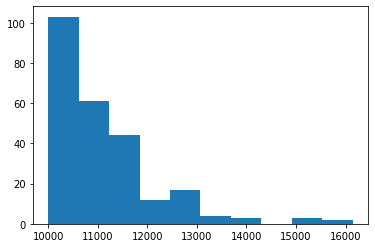

In [10]:
plt.hist(links_lengths)

In [36]:
 df_sim_input

,Link_num,site_a_longitude,site_b_longitude,site_a_latitude,site_b_latitude,F,L,Polarization,a,b,R,A,xa,ya,xb,yb,x,y,z
0,4VZC-LIA0,8.957930,8.958045,47.775708,47.778444,23,0.304946,H,0.1029106172573008,1.0759988443895863,0.496667,NaN,9.462797e+05,5.308584e+06,9.462648e+05,5.308888e+06,"(946272.2665862603,)","(5308736.034959607,)","(0.496667,)"
1,2B6R-A0IR,9.608653,9.605485,47.782211,47.783021,23,0.254575,H,0.1029106172573008,1.0759988443895863,0.520000,NaN,9.949398e+05,5.313279e+06,9.946950e+05,5.313348e+06,"(994817.4112815778,)","(5313313.579368921,)","(0.52,)"
2,7BKD-Q5TI,9.761719,9.777320,47.781570,47.784951,23,1.231489,H,0.1029106172573008,1.0759988443895863,0.506839,NaN,1.006404e+06,5.314202e+06,1.007539e+06,5.314680e+06,"(1006971.7531066014,)","(5314441.318501494,)","(0.506839,)"
3,1L0C-FK6V,9.014082,9.027024,47.784330,47.787951,23,1.052225,V,0.09436057525981735,1.0424400297915115,0.422012,NaN,9.504095e+05,5.309868e+06,9.513469e+05,5.310346e+06,"(950878.2293936288,)","(5310106.966493568,)","(0.422012,)"
4,QXNU-2R6I,9.459127,9.454685,47.806787,47.807136,23,0.335817,H,0.1029106172573008,1.0759988443895863,0.223333,NaN,9.835173e+05,5.315059e+06,9.831817e+05,5.315070e+06,"(983349.4816480066,)","(5315064.359055493,)","(0.223333,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8LGQ-HYQN,8.739286,8.670714,48.991514,49.016097,23,5.723644,H,0.1029106172573008,1.0759988443895863,0.845916,NaN,9.197595e+05,5.442402e+06,9.145419e+05,5.444755e+06,"(917150.6517783704,)","(5443578.35788484,)","(0.845916,)"
237,Q0WN-MVPU,9.852215,9.851769,49.012611,49.013958,23,0.153770,H,0.1029106172573008,1.0759988443895863,0.580000,NaN,1.000894e+06,5.451517e+06,1.000848e+06,5.451664e+06,"(1000870.6809691438,)","(5451590.740630324,)","(0.58,)"
238,T134-NVC4,9.622086,9.643514,49.012016,49.030221,23,2.566705,V,0.09436057525981735,1.0424400297915115,1.183191,NaN,9.840881e+05,5.449952e+06,9.854757e+05,5.452112e+06,"(984781.9277615272,)","(5451031.879338263,)","(1.183191,)"
239,0EW2-K51L,9.751057,9.746478,49.019733,49.023436,23,0.532183,V,0.09436057525981735,1.0424400297915115,0.430000,NaN,9.934334e+05,5.451643e+06,9.930622e+05,5.452024e+06,"(993247.81021633,)","(5451833.71735633,)","(0.43,)"


In [26]:
links_xa = (-links_lengths/2)*np.cos(ang) + links_cent[:,0]
links_xa

array([ 917404.17326562,  923860.74429901,  912415.51525908,
        974913.44092081, 1006874.81612622,  929374.41736577,
        989850.21973832,  938314.21021983,  953274.75388131,
        900051.22630762,  999057.63016118, 1017743.64896429,
        925969.23482506,  952200.31904612,  961518.18043401,
       1004303.32145584,  926624.37898472,  930549.6881089 ,
        898619.65346675,  986315.57953185,  916345.73999418,
        954472.12816662,  899395.64509078,  987094.94695634,
        928125.33836255,  994701.88624717,  902974.90119671,
        928166.41430472,  898112.17399414,  904634.41444673,
        949551.83331402,  970078.99884031,  981236.46923368,
       1008450.52029022, 1004626.08322825,  930511.11499784,
        963110.53890998,  907714.97184045,  923814.60707347,
        944227.98262749,  987109.54968367, 1011499.24380476,
        923589.11494067,  919715.52211667,  924097.02340187,
        932491.01652032,  932403.78243248,  951107.78576679,
        966008.84585895,

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1999.5, 1999.6, 1999.7, 1999.8, 1999.9, 2000. , 2000.1, 2000.2,
        2000.3, 2000.4, 2000.5]),
 <a list of 10 Patch objects>)

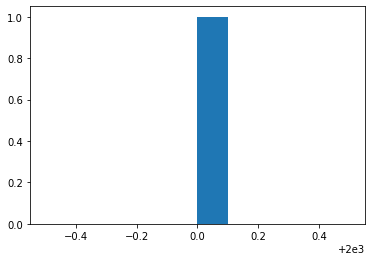

In [19]:
plt.hist(links_lengths)

# True acf parameters

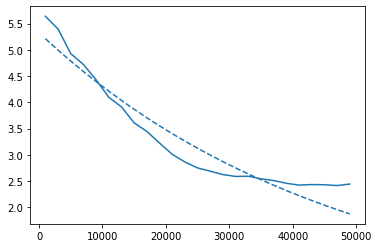

In [32]:
import autocorr_cmls as accml
####################################
###### Autocorrelation radar #######
####################################
data = globals()["ds_radolan_GT_" + agg].raindepth.isel(time=ts).values.ravel().copy()
print(len(data))
temp_nans = np.argwhere(np.isnan(data))
data = np.delete(data, temp_nans)
print(len(data))

# data[12,12] = np.nan
# grid definition for output field
gridx = np.delete(globals()["ds_radolan_GT_" + agg].x_utm.values.ravel(), temp_nans)
gridy = np.delete(globals()["ds_radolan_GT_" + agg].y_utm.values.ravel(), temp_nans)
##########################################
### Excluding zeros from the variogram ###
##########################################
bool_data = np.array(data,dtype=bool)
data = np.compress(bool_data,data)
gridx = np.compress(bool_data,gridx)
gridy = np.compress(bool_data,gridy)
print(len(data))
##########################################
################## Done ##################
##########################################
def make_tuple_arr(arr):
    d_tuple = []
    for i,d in enumerate(arr):
        d_tuple.append(tuple((d,)))
    return d_tuple

data = make_tuple_arr(data)
gridx = make_tuple_arr(gridx)
gridy = make_tuple_arr(gridy)

df = pd.DataFrame({'x': gridx,
                  'y': gridy,
                  'z': data})
ac = accml.Autocorr(df, bw=bandwidth, cutoff_distance_km=cod)
ac(optimize=opt)
alpha = ac.alpha_L; beta = ac.beta_L 
print(alpha, beta)


# print(popt)
fig, ax = plt.subplots()
ax.plot(ac.ac[0],ac.ac[1])
ax.plot(ac.ac[0],acf_original(ac.ac[0],alpha,beta), '--C0')

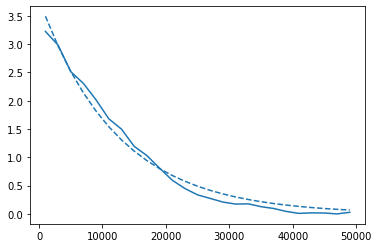

In [44]:
from scipy.optimize import curve_fit
popt, _ = curve_fit(
                f=acf_original, 
                xdata=ac.ac[0]/ac.magnitude_alpha,
                ydata=(ac.ac[1]-np.min(ac.ac[1])/ac.magnitude_beta)
            )
alpha = popt[0]*ac.magnitude_alpha; beta = popt[1]*ac.magnitude_beta
fig, ax = plt.subplots()
ax.plot(ac.ac[0],ac.ac[1]-np.min(ac.ac[1]))
ax.plot(ac.ac[0],acf_original(ac.ac[0],alpha,beta), '--C0')

In [57]:
domain_Lx = round(deg2km(min_lon,
                      max_lon,
                      min_lat,
                      min_lat),1)
domain_Ly = round(deg2km(max_lon,
                      max_lon,
                      min_lat,
                      max_lat),1)
print('Length of domain lon axis is approx. ' + str(domain_Lx) +' km')
print('Length of domain lat axis is approx. ' + str(domain_Ly) +' km')

Length of domain lon axis is approx. 143.0 km
Length of domain lat axis is approx. 159.0 km


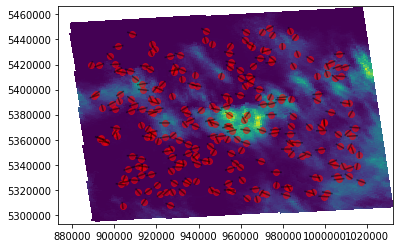

In [58]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(ds_radolan_GT.x_utm.values,
              ds_radolan_GT.y_utm.values,
              globals()['ds_radolan_GT_' + agg_times[0]].isel(time=ts).raindepth.values,
              shading='auto')
ax.plot(links_cent[:,0],links_cent[:,1], 'ro', alpha = 0.5)
line = ax.plot([links_xa,links_xb],
                [links_ya,links_yb],
                'k', alpha=0.5)

In [152]:
def filter_par_arr(array):
    array[array[:,1]==888] = np.nan
    array[array[:,1]==777] = np.nan
    array[array[:,1]==666] = np.nan
    array[array[:,0] < 1e3] = np.nan
    array[array[:,1] > 600] = np.nan
    array[array[:,1] < 1e-2] = np.nan
    array[:,0] = array[:,0] / 1e3 # to make alpha units km
    return array

beta_arr = []
alpha_arr = []
l_names = []
for filename in sorted(os.listdir(fig_path_current)):
    if 'ac_par' in filename:
        name = split_at(filename,'.',1)[0]
        with open(fig_path_current / filename, 'rb') as f:
            arr = pkl.load(f)
        f.close()
        arr = filter_par_arr(arr)
        arr = np.array(arr)
        arr = np.delete(arr,0,0)
        l=int(split_at(name,'_',-1)[1])
        print(l)
        
        beta_arr.append(arr[:,1].T)
        alpha_arr.append(arr[:,0].T)
        
        l_names.append(str(l * 100))
# sill_arr = np.concatenate(sill_arr)
beta_arr = np.array(beta_arr)
alpha_arr = np.array(alpha_arr)

df_beta = pd.DataFrame(beta_arr.T,columns=l_names)
df_alpha = pd.DataFrame(alpha_arr.T,columns=l_names)


1
20


Text(1, 4.106637571128591, 'rad\\n$\\beta_L$')

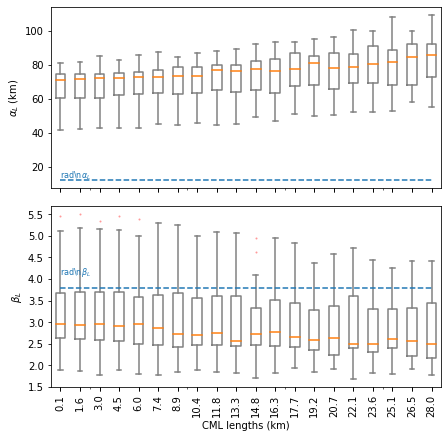

In [120]:
fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=True)
flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                  linestyle='none', markeredgecolor='g')

df_c = df_alpha.copy()
cols = df_c.columns.values.astype(np.float) / 1e3
cols.astype(str)
d = dict(zip(df_c.columns.values, cols))
df_c.rename(columns=d,inplace=True)

df_c.plot(kind='box',ax=ax[0],
             color=dict(boxes='grey', whiskers='grey', medians='C1', caps='grey'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(marker='o', 
                             markerfacecolor='r', 
                             markersize=2,
                             linestyle='none',
                             markeredgecolor='None', 
                             alpha=0.4),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, rot=90)

df_c = df_beta.copy()
cols = df_c.columns.values.astype(np.float) / 1e3
cols.astype(str)
d = dict(zip(df_c.columns.values, cols))
df_c.rename(columns=d,inplace=True)

df_c.plot(kind='box',ax=ax[1],
             color=dict(boxes='grey', whiskers='grey', medians='C1', caps='grey'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(marker='o', 
                             markerfacecolor='r', 
                             markersize=2,
                             linestyle='none',
                             markeredgecolor='None', 
                             alpha=0.4),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, rot=90)


plt.subplots_adjust(hspace=0.1)
ax[0].set_ylabel(r'$\alpha_L$ (km)')
ax[1].set_ylabel(r'$\beta_L$')
ax[1].set_xlabel('CML lengths (km)')

rad_range = alpha / 1e3
rad_sill  = beta
line = range(1,len(cml_lengths)+1)
ax[0].plot(line, np.ones_like(line) * rad_range, '--')
ax[0].text(1, rad_range+rad_range/12, r'rad\n$\alpha_L$', fontsize=8, color='C0')
ax[1].plot(line, np.ones_like(line) * rad_sill, '--')
ax[1].text(1, rad_sill+rad_sill/12, r'rad\n$\beta_L$', fontsize=8, color='C0')


# fig.savefig(str(fig_path_current) + '/pars_ts_' + str(ts) + '.png', bbox_inches='tight')
# print(fig_path_current)